# Tutourial 1

In this tutourial we will set up, mesh and simulate a basic membrane using the particle model. First we will import the right modules and set up some basic paramets for the simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os

sys.path.append(os.path.abspath(".."))
from PSS.particleSystem.ParticleSystem import ParticleSystem

# dictionary of required parameters
params = {
    # model parameters
    "k": 2,  # [N/m]     spring stiffness
    "c": 1,  # [N s/m] damping coefficient
    "m_segment": 1,  # [kg] mass of each node
    # simulation settings
    "dt": 0.1,  # [s]       simulation timestep
    "t_steps": 1000,  # [-]      number of simulated time steps
    "abs_tol": 1e-50,  # [m/s]     absolute error tolerance iterative solver
    "rel_tol": 1e-5,  # [-]       relative error tolerance iterative solver
    "max_iter": 1e5,  # [-]       maximum number of iterations
    # physical parameters
    "g": 9.807,  # [m/s^2]   gravitational acceleration
}

## Meshing
Meshing is fully manual at the moment. This means it is up to us to define a clever discretization for the object we want to simulate. For this tutourial we will simulate a ribbon experiencing an out of plane force. 

It is important to format the data such that we can feed it to the simulation library the way it expects it. We will have to supply three sturctures:

- **The initial conditions**: This represents the starting locations, velocities, masses and the boundary conditions of the nodes. Becuase they're point masses the only supported boundary conditions are fixed and free, provided by a boolean `True` or `False`. The structure is a list with an entry for each node. It has the following form:
```python
    initial_conditions = [
    [np.array([x_1, y_1, z_1]), np.array[u_1, v_1, w_1]), m_1, Fixed_1],
    ...,
    [np.array[x_n, y_n, z_n]), np.array[u_n, v_n, w_n]), m_n, Fixed_n]
    ]
```
- **The connectivity matrix**: This is an n by 4 array where n is the total number of nodes, and the 4 column positions are [index of point a, index of point b, k, c, linktype="default"]. Point a is linked to point b, k is the stiffness and c is the damping.
Example:
```python
   array([[4, 1, 3.3, 1.,"default"],
          [4, 0, 2.5, 1.,"pulley"],
          [1, 2, 3.3, 1.,"noncompressive"],
          [3, 0, 2.5, 1.,"nontensile"],
          ...])
```
- **The external forces**: The external forces are passed to the simulation at every timestep. They are represented by F_x, F_y, F_z components for each node, but flattened into a 1D list. This allows the forces to be recalculated each timestep to take into account geometric non-linearities. The list has the form of:
```python
F_ext = [F_x1, F_y1, F_z1, ..., F_xn, F_yn, F_zn]
```

In [2]:
# grid discretization
# We will use a rectanular grid of 6 x 3, which is 6 x 4 nodes spaced 1 unit apart
grid_width = 3
grid_length = 6

params["l0"] = 1
params["n"] = (grid_width + 1) * (grid_length + 1)

# Setting up the coordinates for the nodes
mesh = np.meshgrid(
    np.linspace(0, grid_length, grid_length + 1),
    np.linspace(0, grid_width, grid_width + 1),
)


# Fitting it into the required format and setting boundary conditions
# A the core of it this section converts the coordinate grids into a list of nodes
initial_conditions = []
xy_coordinates = np.column_stack(list(zip(mesh[0], mesh[1]))).T
xyz_coordinates = np.column_stack((xy_coordinates, np.zeros(len(xy_coordinates)).T))

for xyz in xyz_coordinates:
    fixed = False
    if (
        xyz[0] == 0 or xyz[0] == grid_length
    ):  # For fixing the other boundary use "xyz[1] == 0 or xyz[1] == grid_width"
        fixed = True
    initial_conditions.append([xyz, np.zeros(3), params["m_segment"], fixed])

# Setting up the connectivity matrix
connections = []

# We know that all the nodes are connected to those of the next row, which is grid_length+1 units further
for i, node in enumerate(
    initial_conditions[: -grid_length - 1]
):  # adding connextions in y-axis
    connections.append([i, i + grid_length + 1, params["k"], params["c"]])

# We can do the same for the connections between the columns
for i, node in enumerate(initial_conditions):  # adding connections in x-axis
    if (i + 1) % (
        grid_length + 1
    ):  # Using modulus operator to exclude the nodes at the end of a row
        connections.append([i, i + 1, params["k"], params["c"]])

print(f"type of connections: {type(connections)}, shape: {np.shape(connections)}")
print(f"connections: {connections}")
print(
    f"type of initial_conditions: {type(initial_conditions)}, len: {len(initial_conditions)}"
)
print(f"initial_conditions: {initial_conditions}")
print(f"type of params: {type(params)}, len of params: {len(params)}")
print(f"params: {params}")

type of connections: <class 'list'>, shape: (45, 4)
connections: [[0, 7, 2, 1], [1, 8, 2, 1], [2, 9, 2, 1], [3, 10, 2, 1], [4, 11, 2, 1], [5, 12, 2, 1], [6, 13, 2, 1], [7, 14, 2, 1], [8, 15, 2, 1], [9, 16, 2, 1], [10, 17, 2, 1], [11, 18, 2, 1], [12, 19, 2, 1], [13, 20, 2, 1], [14, 21, 2, 1], [15, 22, 2, 1], [16, 23, 2, 1], [17, 24, 2, 1], [18, 25, 2, 1], [19, 26, 2, 1], [20, 27, 2, 1], [0, 1, 2, 1], [1, 2, 2, 1], [2, 3, 2, 1], [3, 4, 2, 1], [4, 5, 2, 1], [5, 6, 2, 1], [7, 8, 2, 1], [8, 9, 2, 1], [9, 10, 2, 1], [10, 11, 2, 1], [11, 12, 2, 1], [12, 13, 2, 1], [14, 15, 2, 1], [15, 16, 2, 1], [16, 17, 2, 1], [17, 18, 2, 1], [18, 19, 2, 1], [19, 20, 2, 1], [21, 22, 2, 1], [22, 23, 2, 1], [23, 24, 2, 1], [24, 25, 2, 1], [25, 26, 2, 1], [26, 27, 2, 1]]
type of initial_conditions: <class 'list'>, len: 28
initial_conditions: [[array([0., 0., 0.]), array([0., 0., 0.]), 1, True], [array([1., 0., 0.]), array([0., 0., 0.]), 1, False], [array([2., 0., 0.]), array([0., 0., 0.]), 1, False], [array([3.

## Checking the mesh
Now that we have set up the mesh, we can check if all the nodes and connection are in the right place by plotting it. 

Text(0.5, 0.92, 'Initial state')

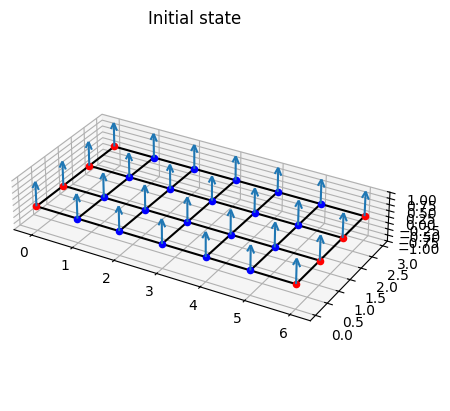

In [3]:
# Applying external forces
# Just using a simple load in z for this example
f_ext = np.array([[0, 0, 1] for i in range(params["n"])]).flatten()


# Plotting mesh with external forces
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for i, node in enumerate(initial_conditions):
    if node[3]:
        ax.scatter(node[0][0], node[0][1], node[0][2], color="red", marker="o")
    else:
        ax.scatter(node[0][0], node[0][1], node[0][2], color="blue", marker="o")

    ax.quiver(
        *node[0].tolist(), f_ext[3 * i], f_ext[3 * i + 1], f_ext[3 * i + 2], length=1
    )

for connection in connections:
    line = np.column_stack(
        [initial_conditions[connection[0]][0], initial_conditions[connection[1]][0]]
    )

    ax.plot(line[0], line[1], line[2], color="black")

ax.set_box_aspect((grid_length, grid_width, 1))
ax.set_zlim(-1, 1)
plt.title("Initial state")

## Running the simulation
Now we will set up the simulation itself. We need to determine for ourselves at what point we consider the simulation complete. In this case I have chosen a cutoff value for the kinetic energy. However, the simulation uses kinetic dampening so we cannot simply stop the simulation once the cutoff has been reached for the first time. This is because the velocities are all periodically set to zero. Hence we look at the highest value in a window of ten timesteps and stop the simulation when the highest one of the window is below our cutoff.  

In [4]:
# Now we can setup the particle system and simulation
PS = ParticleSystem(connections, initial_conditions, params)

t_vector = np.linspace(
    params["dt"], params["t_steps"] * params["dt"], params["t_steps"]
)
final_step = 0
E_kin = []
f_int = []

# And run the simulation
for step in t_vector:
    PS.kin_damp_sim(f_ext)

    final_step = step
    (
        x,
        v,
    ) = PS.x_v_current
    E_kin.append(np.linalg.norm(v * v))
    f_int.append(np.linalg.norm(PS.f_int))

    converged = False
    if step > 10:
        if np.max(E_kin[-10:-1]) <= 1e-29:
            converged = True
    if converged and step > 1:
        print("Kinetic damping PS converged", step)
        break

Kinetic damping PS converged 54.6
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.55111512e-16
 -1.13323254e-40 -1.00000000e+00  4.44089210e-16 -2.18811929e-40
 -1.00000000e+00 -7.77156117e-16 -2.75477850e-40 -1.00000000e+00
  1.22124533e-15 -2.18811929e-40 -1.00000000e+00 -2.22044605e-16
 -1.13323254e-40 -1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.55111512e-16  0.00000000e+00 -1.00000000e+00  4.44089210e-16
  0.00000000e+00 -1.00000000e+00 -7.77156117e-16  0.00000000e+00
 -1.00000000e+00  1.22124533e-15  0.00000000e+00 -1.00000000e+00
 -2.22044605e-16  0.00000000e+00 -1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.55111512e-16  0.00000000e+00 -1.00000000e+00
  4.44089210e-16  0.00000000e+00 -1.00000000e+00 -7.77156117e-16
  0.00000000e+00 -1.00000000e+00  1.22124533e-15  0.00000000e+00
 -1.00000000e+00 -2.22044605e-16  0.00000000e+00 -1.0000

Let's take a look at the convergence behaviour of the simulation and see what we can learn. Let's also plot another common convergence criterium for comparison, the internal forces. 

We see that towards the end of the simulation the curve starts to flatten out for the Kinetic energy. This indicates that further simulation has decreasing marginal returns. 

The internal forces stabilise onto a set value and osclilate around this value. These dampened oscilations are very hard to visualise in one plot because of the diminishing size of the oscilations. 

In [ ]:
# Let's check the convergence plot

# Change these to zoom in on a specific region.
plotstop = len(E_kin)
plotstart = 0

plt.plot(t_vector[:plotstop], E_kin[:plotstop], label="Kinetic Energy [J]")
plt.plot(
    t_vector[plotstart:plotstop], f_int[plotstart:plotstop], label="Internal Forces [N]"
)

# Filtering out the peaks to mark where the kinetic damping algorithm kicked in.
df = pd.DataFrame(E_kin, index=t_vector[0:plotstop])
peaksonly = df[(df[0].shift(1) < df[0]) & (df[0].shift(-1) < df[0])]
plt.scatter(
    peaksonly.index,
    peaksonly[0],
    c="r",
    linewidths=1,
    marker="+",
    label="Kinetic Damping Enacted",
)

plt.legend()
plt.yscale("log")
plt.title("Convergence Plot")
plt.xlabel("Time [s]")
plt.ylabel("Quantity of interest")
plt.xlim(t_vector[0], t_vector[plotstop])

## Reviewing results

To view the results we will once again plot the system in 3D. To do this we first have to extract the current positions from the system. After that we can re-use the code from the beginning to visualise our result. 

In [ ]:
final_positions = [
    [particle.x, particle.v, particle.m, particle.fixed] for particle in PS.particles
]

# Plotting final results
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for i, node in enumerate(final_positions):
    if node[3]:
        ax.scatter(node[0][0], node[0][1], node[0][2], color="red", marker="o")
    else:
        ax.scatter(node[0][0], node[0][1], node[0][2], color="blue", marker="o")

    ax.quiver(
        *node[0].tolist(), f_ext[3 * i], f_ext[3 * i + 1], f_ext[3 * i + 2]
    )  # , length  = 0.3)

for connection in connections:
    line = np.column_stack(
        [final_positions[connection[0]][0], final_positions[connection[1]][0]]
    )

    ax.plot(line[0], line[1], line[2], color="black")

ax.legend(["Fixed nodes", "Forces", "Free nodes"])

# Finding bounding box and setting aspect ratio
xyz = np.array([particle.x for particle in PS.particles])
bb = [np.ptp(i) for i in xyz.T]
ax.set_box_aspect(bb)

plt.title("Final state")